In [1]:
from random import choices

import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from models.observableSubgraph import create_subgraph, simulate_observable_nodes
from models.seeding import Seeding
from models.independentCascade import IndependentCascade
from utils import alter_connections

# Import NetHept Network Data

In [2]:
file = open('data/weic-graphdata/hep.txt', 'r')
first_line = file.readline()
meta = first_line.split()
num_nodes = int(meta[0])
num_edges = int(meta[1])
print(f"|V|: {num_nodes}, |E|: {num_edges}")

edges = [line.strip().split() for line in file.readlines()]
edges = [(int(e[0]), int(e[1])) for e in edges]

|V|: 15233, |E|: 58891


In [3]:
# create a directed graph object
# note: there are duplicated edges. If you want to keep the duplicates, use MultiDiGraph instead
graph = nx.DiGraph()
graph.add_edges_from(edges)
print(f"Number of nodes: {graph.number_of_nodes()}\nNumber of edges: {graph.number_of_edges()}")

Number of nodes: 15233
Number of edges: 32235


# Simulate Information Spreading on Original NetHept with Varying Visibilities

In [4]:
# run on original graph
results_spreads_original = [] 
results_deg_assorts_original = []
results_visibility_original = []

nodes = list(graph.nodes)
deg_assort = nx.degree_assortativity_coefficient(graph, x = 'out', y = 'out')
print(f"Running for the original graph with deg assort {deg_assort}")

visibility_list = [k * 0.01 for k in range(1, 22, 2)]
for target_visibility in visibility_list: # iterate over varying network visibilities
    spreads = []
    for _ in range(5): # repeat experiment for 5 times to compute average spread
        # construct an obserable subgraph
        fully_observ_O, boundary_nodes = simulate_observable_nodes(graph, target_visibility)
        observable_nodes = fully_observ_O + boundary_nodes
        observable_graph = create_subgraph(graph, observable_nodes)
        
        # select initial seeds from the observable nodes using weighted degree-based heuristic 
        seeding = Seeding(observable_graph, method = 'weighted-degree-based')
        seeds = seeding(boundary_nodes, weight = 3, num_seed = 5)
        
        # simulate information spreading using weighted IC model
        ic_model = IndependentCascade(graph, seeds)
        activated_nodes = ic_model.simulate()
        spreads.append(len(activated_nodes))
        
    avg_spread = np.mean(spreads)
    print(f"\tvisibility: {target_visibility}, avg spread: {avg_spread}")
    results_spreads_original.append(avg_spread)
    results_deg_assorts_original.append(deg_assort)
    results_visibility_original.append(target_visibility)

Running for the original graph with deg assort 0.3161257813793155
	visibility: 0.01, avg spread: 48.4
	visibility: 0.03, avg spread: 76.4
	visibility: 0.05, avg spread: 102.6
	visibility: 0.07, avg spread: 119.0
	visibility: 0.09, avg spread: 117.6
	visibility: 0.11, avg spread: 117.6
	visibility: 0.13, avg spread: 92.6
	visibility: 0.15, avg spread: 100.0
	visibility: 0.17, avg spread: 91.4
	visibility: 0.19, avg spread: 114.6
	visibility: 0.21, avg spread: 112.0


# Alter NetHept to Create New Graphs with Varying Degree Assortativities

In [5]:
new_graphs = []
deg_assortativity = []
for p in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    new_graph = alter_connections(graph, num_edges = int(p * graph.number_of_edges()))
    new_graphs.append(new_graph)
    deg_assortativity.append(nx.degree_assortativity_coefficient(new_graph, x = 'out', y = 'out'))
print(deg_assortativity)

[0.31415800630862767, 0.30470454412546244, 0.29149452454362434, 0.2658703627802869, 0.24220223503971702, 0.21510622088489068, 0.19562828594377785, 0.16414125318627096, 0.15007544300779938, 0.1289493357670261, 0.11354126713230739, 0.0953540261918207]


# Run IC on Partially Observable Parts of New Graphs

In [6]:
results_spreads = []
results_deg_assorts = []
results_visibility = []
for i, g in enumerate(new_graphs): # iterate over the new, altered networks
    nodes = list(g.nodes)
    print(f"Running for graph with deg assort {deg_assortativity[i]}")
    for target_visibility in visibility_list: # iterate over varying network visibilities
        spreads = []
        for _ in range(5): # repeat experiment for 5 times to compute average spread
            # construct an obserable subgraph
            fully_observ_O, boundary_nodes = simulate_observable_nodes(g, target_visibility)
            observable_nodes = fully_observ_O + boundary_nodes
            observable_graph = create_subgraph(g, observable_nodes)
            
            # select initial seeds from the observable nodes using weighted degree-based heuristic 
            seeding = Seeding(observable_graph, method = 'weighted-degree-based')
            seeds = seeding(boundary_nodes, weight = 3, num_seed = 5)
            
            # simulate information spreading using weighted IC model
            ic_model = IndependentCascade(g, seeds)
            activated_nodes = ic_model.simulate()
            spreads.append(len(activated_nodes))
            
        avg_spread = np.mean(spreads)
        print(f"\tvisibility: {target_visibility}, avg spread: {avg_spread}")
        results_spreads.append(avg_spread)
        results_deg_assorts.append(deg_assortativity[i])
        results_visibility.append(target_visibility)

Running for graph with deg assort 0.31415800630862767
	visibility: 0.01, avg spread: 64.8
	visibility: 0.03, avg spread: 86.6
	visibility: 0.05, avg spread: 109.8
	visibility: 0.07, avg spread: 119.6
	visibility: 0.09, avg spread: 98.8
	visibility: 0.11, avg spread: 112.2
	visibility: 0.13, avg spread: 96.6
	visibility: 0.15, avg spread: 108.0
	visibility: 0.17, avg spread: 117.4
	visibility: 0.19, avg spread: 114.8
	visibility: 0.21, avg spread: 99.0
Running for graph with deg assort 0.30470454412546244
	visibility: 0.01, avg spread: 57.2
	visibility: 0.03, avg spread: 82.6
	visibility: 0.05, avg spread: 105.2
	visibility: 0.07, avg spread: 117.8
	visibility: 0.09, avg spread: 158.0
	visibility: 0.11, avg spread: 170.8
	visibility: 0.13, avg spread: 146.0
	visibility: 0.15, avg spread: 151.0
	visibility: 0.17, avg spread: 188.4
	visibility: 0.19, avg spread: 155.4
	visibility: 0.21, avg spread: 168.6
Running for graph with deg assort 0.29149452454362434
	visibility: 0.01, avg spread: 

# Combine and Visualize Results

In [7]:
results = pd.DataFrame.from_dict({
        "avg_spread" : results_spreads,
        "deg_assortativity": results_deg_assorts,
        "visibility": results_visibility,
    })
results_original = pd.DataFrame.from_dict({
        "avg_spread" : results_spreads_original,
        "deg_assortativity": results_deg_assorts_original,
        "visibility": results_visibility_original,
    })
results['deg_assortativity_str'] = results["deg_assortativity"].round(2).astype(str)
results_original['deg_assortativity_str'] = results_original["deg_assortativity"].round(2).astype(str) + " (original)"

result_df = pd.concat([results_original, results])
result_df["visibility"] = result_df["visibility"]  * 100

result_df.to_csv("results/results_nethept.csv", index = False)

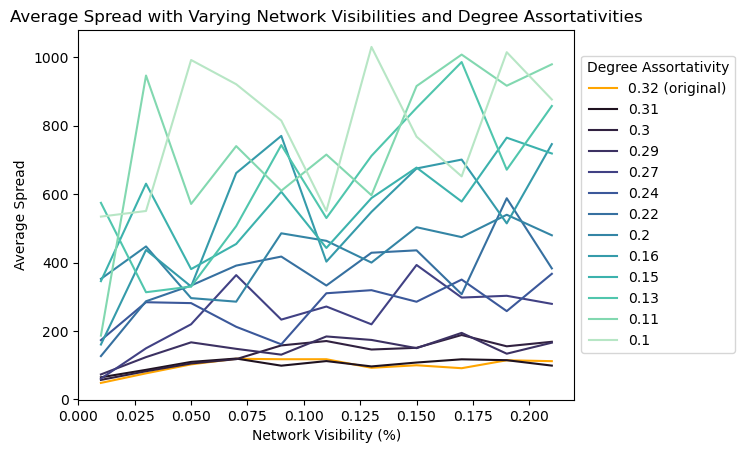

In [25]:
sns.lineplot(data = results_original, x = "visibility",
             y = "avg_spread", 
             color = "orange",
             label = f"{results_deg_assorts_original[0].round(2).astype(str)} (original)")
sns.lineplot(data = results, x = "visibility",
             y = "avg_spread", hue = "deg_assortativity_str",
            palette = "mako")
plt.ylabel("Average Spread")
plt.xlabel("Network Visibility (%)")
plt.legend(title = "Degree Assortativity", bbox_to_anchor=(1, 0.95))
plt.title("Average Spread with Varying Network Visibilities and Degree Assortativities")
plt.savefig("results/fig/result_nethept.png", dpi = 300,  bbox_inches="tight")